In [1]:
import torch
import sys

from torch.nn import BCELoss, CrossEntropyLoss
from torch.utils.data import random_split

sys.path.append("../")
from datasets import RealDataset, load_libsvm_data
from targets import TargetFunction


In [2]:
dtype = torch.float64
device = 'cpu'
training_fraction=0.8
generator = torch.Generator().manual_seed(12131415)

def train_test_split(X, y, training_fraction = 0.8):
    tr_ind, te_ind = random_split(range(X.shape[0]), [training_fraction, 1 - training_fraction], generator=generator)
    return X[tr_ind, :], X[te_ind, :], y[tr_ind], y[te_ind]

X, y = load_libsvm_data(datapath="/data/mrando/phishing/phishing", dtype=dtype, device=device)
#X_te, y_te = load_libsvm_data(datapath="/data/mrando/ijcnn1/ijcnn1.t", dtype=dtype, device=device)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, training_fraction=training_fraction)




In [3]:
def standardize(X, y):
    X_new = (X - X.mean())/X.std()
    y_new = y.clone()
    y_new[y_new < 0] = 0
    return X_new, y_new

In [4]:
X_tr.dtype, y_tr.dtype

(torch.float64, torch.float64)

In [6]:
training_set = RealDataset(*standardize(X_tr, y_tr))
test_set     = RealDataset(*standardize(X_te, y_te))


In [7]:
class BBClassification(TargetFunction):
    
    def __init__(self, dataset, lam = 1e-3,seed: int = 12131415):
        super().__init__(dataset.n, seed)
        self.dataset = dataset
        self.lam = lam
        self.loss = BCELoss(reduction='none')
        
    def __call__(self, w, z=None, elem_wise = False):
        if z is None:
            return self.loss(torch.sigmoid(torch.matmul(w, self.dataset.X.T)), self.dataset.y.repeat(w.shape[0]).view(w.shape[0], -1)).mean(dim=1, keepdim=True) 
        if not elem_wise:
            return self.loss(torch.sigmoid(torch.matmul(w, self.dataset.X.T[:, z])), self.dataset.y[z].repeat(w.shape[0]).view(w.shape[0], -1)).mean(dim=1, keepdim=True)
        return self.loss(torch.einsum('bd,bd->b', self.dataset.X[z, :], w).sigmoid(), self.dataset.y[z]).view(z.shape[0], 1).mean(dim=1, keepdim=True)
 

In [8]:
w = torch.full((3, training_set.d), 1.0, device=device, dtype=dtype)

w[0, -1] = 1.0

target = BBClassification(training_set, seed=12314145)

z = torch.Tensor([0, 2, 3]).to(dtype=torch.int64)

print(target(w, z, elem_wise=True))

loss = BCELoss(reduction='none')




tensor([[0.6931],
        [0.6931],
        [0.6931]], dtype=torch.float64)


In [9]:
from svrz.optimizers import SSZD, OSVRZ, SpiderSZO, ZOSVRG_CoordRand
from svrz.directions import QRDirections

d = training_set.d
l = d
seed = 1231415
opt2 = OSVRZ(P = QRDirections(d=d,l=l, dtype=dtype, device=device, seed=seed), seed=seed)
opt = ZOSVRG_CoordRand(d = d, l = l)


In [10]:
w = torch.ones((1, training_set.d), device=device, dtype=dtype) * 10

from math import sqrt
gamma = lambda k : 1/ sqrt(k + 1)
h = lambda k : max(1e-1 / sqrt(k + 1), 1e-5)



In [11]:
ris2=  opt2.optimize(target, w, m=10, T= 200, gamma=0.01,h=h)
#ris=  opt.optimize(target, w, m=10, T= 1000, gamma=0.001,h=h)



100%|██████████| 200/200 [00:15<00:00, 13.29it/s, k=199/200, f_k=0.165, time=0.0875]


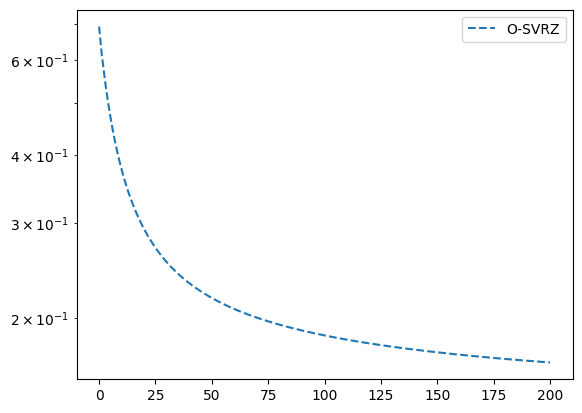

In [12]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
#ax.plot(range(len(ris['f_values']) ), ris['f_values'], '--', label='ZO-SVRG-Coord-Rand')
ax.plot(range(len(ris2['f_values']) ), ris2['f_values'], '--', label = 'O-SVRZ')
ax.set_yscale('log')
ax.legend()

In [13]:
w = ris2['x']
print(w)

tensor([[ 9.7884,  9.9658,  9.8869, 10.0452,  9.9833,  9.5721,  9.8244,  9.5042,
         10.0473,  9.9574, 10.0035, 10.0453, 10.0950,  9.0243, 10.1533,  9.7058,
         10.0041, 10.0718, 10.0782, 10.0130,  9.9790,  9.9500,  9.9617,  9.9519,
          9.8341,  9.9652,  9.8947, 10.1527, 10.2010,  9.9137, 10.1764,  9.9816,
          9.8006, 10.9039, 10.2614,  9.6405,  9.9607,  9.8931,  9.6106, 10.0512,
          9.9794, 10.0130, 10.3754,  9.7972,  9.9176,  9.8699, 10.1574,  9.9529,
         10.0779, 10.3260,  9.9196,  9.9518, 10.0148, 10.1307, 10.0701,  9.5430,
         10.3928, 10.1815, 10.0059,  9.9196,  9.9614,  9.9859, 10.0032, 10.6655,
          9.8867, 10.0074,  9.8122, 10.0639]], dtype=torch.float64)


In [17]:
((torch.sigmoid(torch.matmul(w, test_set.X.T)) > 0.5).to(torch.int64) != test_set.y).to(torch.float64).mean()# / test_set.y.shape[0]

tensor(0.0670, dtype=torch.float64)

In [19]:
((torch.sigmoid(torch.matmul(w, training_set.X.T)) > 0.5).to(torch.int64) != training_set.y).to(torch.float64).mean() #/ training_set.y.shape[0]


tensor(0.0647, dtype=torch.float64)